In [1]:
#import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.utils import shuffle
from random import randint
import matplotlib.gridspec as gridspec

import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Actications
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils
import tensorflow.keras.callbacks
from functools import partial

In [2]:
def get_images(directory):
    Images = []
    Labels = []  # 0 for Building , 1 for forest, 2 for glacier, 3 for mountain, 4 for Sea , 5 for Street
    label = 0
    
    for labels in os.listdir(directory): #Main Directory where each class label is present as folder name.
        if labels == 'glacier': #Folder contain Glacier Images get the '2' class label.
            label = 2
        elif labels == 'sea':
            label = 4
        elif labels == 'buildings':
            label = 0
        elif labels == 'forest':
            label = 1
        elif labels == 'street':
            label = 5
        elif labels == 'mountain':
            label = 3
        
        for image_file in os.listdir(directory+labels): #Extracting the file name of the image from Class Label folder
            image = cv2.imread(directory+labels+r'/'+image_file) #Reading the image (OpenCV)
            image = cv2.resize(image,(150,150)) #Resize the image, Some images are different sizes. (Resizing is very Important)
            Images.append(image)
            Labels.append(label)
    
    return shuffle(Images,Labels,random_state=817328462) #Shuffle the dataset you just prepared.

def get_classlabel(class_code):
    labels = {2:'glacier', 4:'sea', 0:'buildings', 1:'forest', 5:'street', 3:'mountain'}
    
    return labels[class_code]

In [3]:
Images, Labels = get_images('/kaggle/input/intel-image-classification/seg_train/seg_train/') #Extract the training images from the folders.

Images = np.array(Images) #converting the list of images to numpy array.
Labels = np.array(Labels)

In [4]:
print("Shape of Images:",Images.shape)
print("Shape of Labels:",Labels.shape)

Shape of Images: (14034, 150, 150, 3)
Shape of Labels: (14034,)


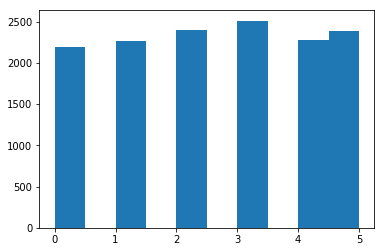

In [5]:
#check distribution of data
plt.hist(Labels)
plt.show()

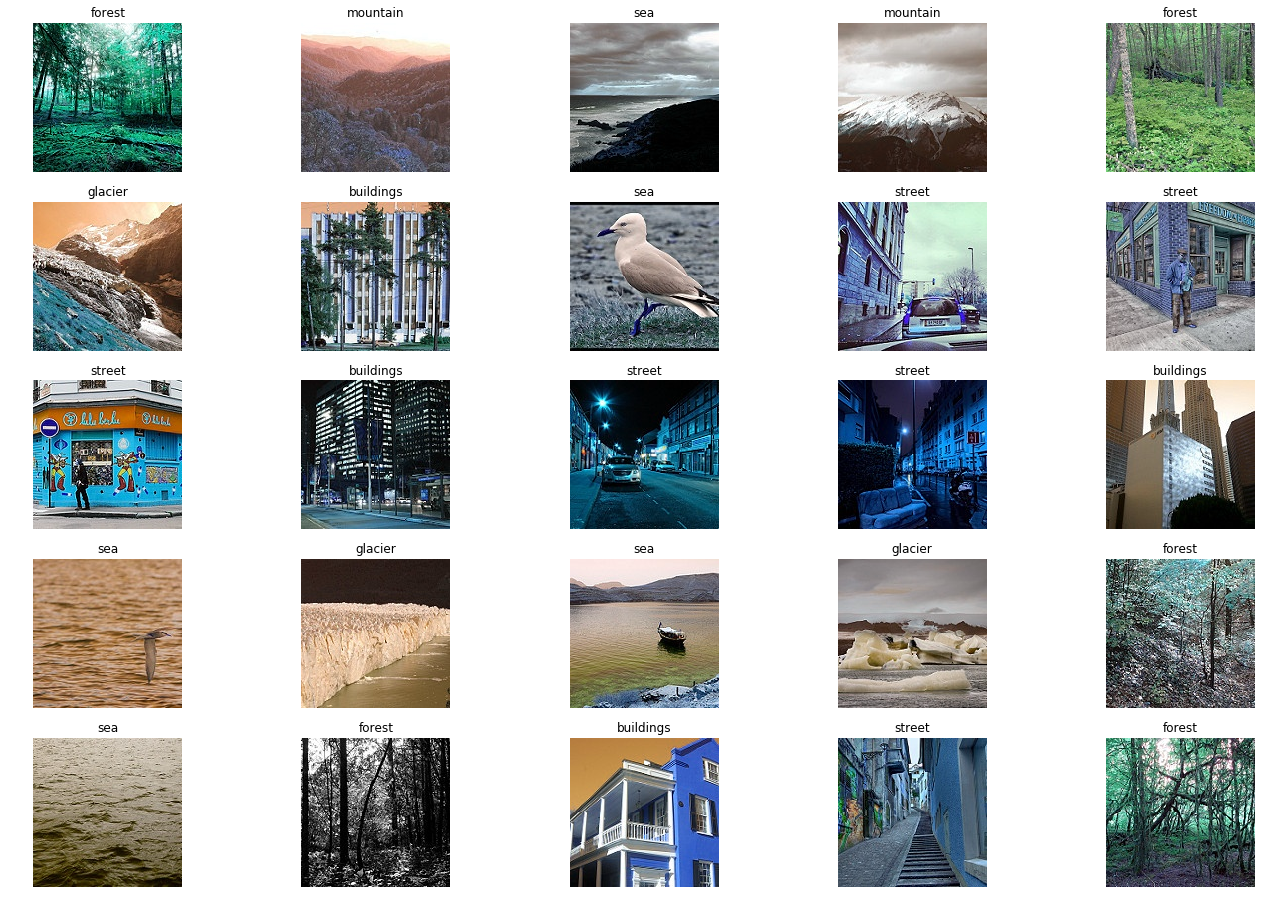

In [6]:
f,ax = plt.subplots(5,5) 
f.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = randint(0,len(Images))
        ax[i,j].imshow(Images[rnd_number])
        ax[i,j].set_title(get_classlabel(Labels[rnd_number]))
        ax[i,j].axis('off')

In [7]:
model = Models.Sequential()

model.add(Layers.Conv2D(512,(3,3),activation=partial(tensorflow.nn.leaky_relu, alpha=0.01),input_shape=(150,150,3)))
model.add(Layers.Conv2D(256,(3,3),activation=partial(tensorflow.nn.leaky_relu, alpha=0.01)))
model.add(Layers.MaxPool2D(3,3))
model.add(Layers.Conv2D(128,(3,3),activation=partial(tensorflow.nn.leaky_relu, alpha=0.01)))
model.add(Layers.Conv2D(64,(3,3),activation=partial(tensorflow.nn.leaky_relu, alpha=0.01)))
model.add(Layers.MaxPool2D(3,3))
model.add(Layers.Flatten())
model.add(Layers.Dense(128,activation=partial(tensorflow.nn.leaky_relu, alpha=0.01)))
model.add(Layers.Dense(64,activation=partial(tensorflow.nn.leaky_relu, alpha=0.01)))
model.add(Layers.Dropout(rate=0.5))
model.add(Layers.Dense(6,activation='softmax'))

model.compile(optimizer=Optimizer.Adam(lr=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 512)     14336     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 256)     1179904   
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 128)       295040    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 44, 44, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

In [8]:
callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
# This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.
trained = model.fit(Images,Labels,epochs=30,validation_split=0.30, callbacks=[callback])

Train on 9823 samples, validate on 4211 samples
Epoch 1/30
9823/9823 [==============================] - 154s 16ms/sample - loss: 1.6009 - accuracy: 0.4179 - val_loss: 1.0708 - val_accuracy: 0.5825
Epoch 2/30
9823/9823 [==============================] - 146s 15ms/sample - loss: 1.1297 - accuracy: 0.5614 - val_loss: 0.9197 - val_accuracy: 0.6732
Epoch 3/30
9823/9823 [==============================] - 146s 15ms/sample - loss: 1.0041 - accuracy: 0.6153 - val_loss: 0.8131 - val_accuracy: 0.6901
Epoch 4/30
9823/9823 [==============================] - 146s 15ms/sample - loss: 0.8779 - accuracy: 0.6819 - val_loss: 0.7475 - val_accuracy: 0.7262
Epoch 5/30
9823/9823 [==============================] - 146s 15ms/sample - loss: 0.7516 - accuracy: 0.7321 - val_loss: 0.6476 - val_accuracy: 0.7706
Epoch 6/30
9823/9823 [==============================] - 146s 15ms/sample - loss: 0.6575 - accuracy: 0.7784 - val_loss: 0.6140 - val_accuracy: 0.7913
Epoch 7/30
9823/9823 [==============================] - 14

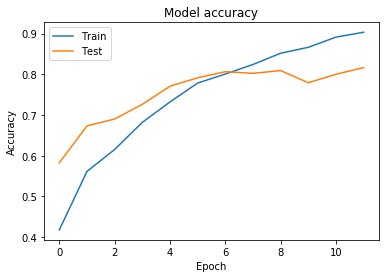

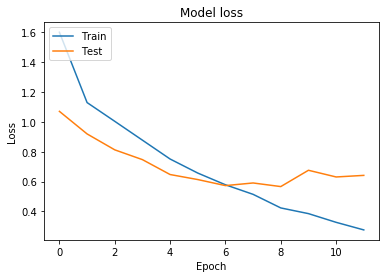

In [9]:
plt.plot(trained.history['accuracy'])
plt.plot(trained.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(trained.history['loss'])
plt.plot(trained.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [10]:
test_images,test_labels = get_images('/kaggle/input/intel-image-classification/seg_test/seg_test/')
test_images = np.array(test_images)
test_labels = np.array(test_labels)
model.evaluate(test_images,test_labels, verbose=1)

3000/3000 [==============================] - 11s 4ms/sample - loss: 0.6215 - accuracy: 0.8250


[0.6214508528312047, 0.825]

In [11]:
pred_images,no_labels = get_images('/kaggle/input/intel-image-classification/seg_pred/')
pred_images = np.array(pred_images)
pred_images.shape

(7301, 150, 150, 3)

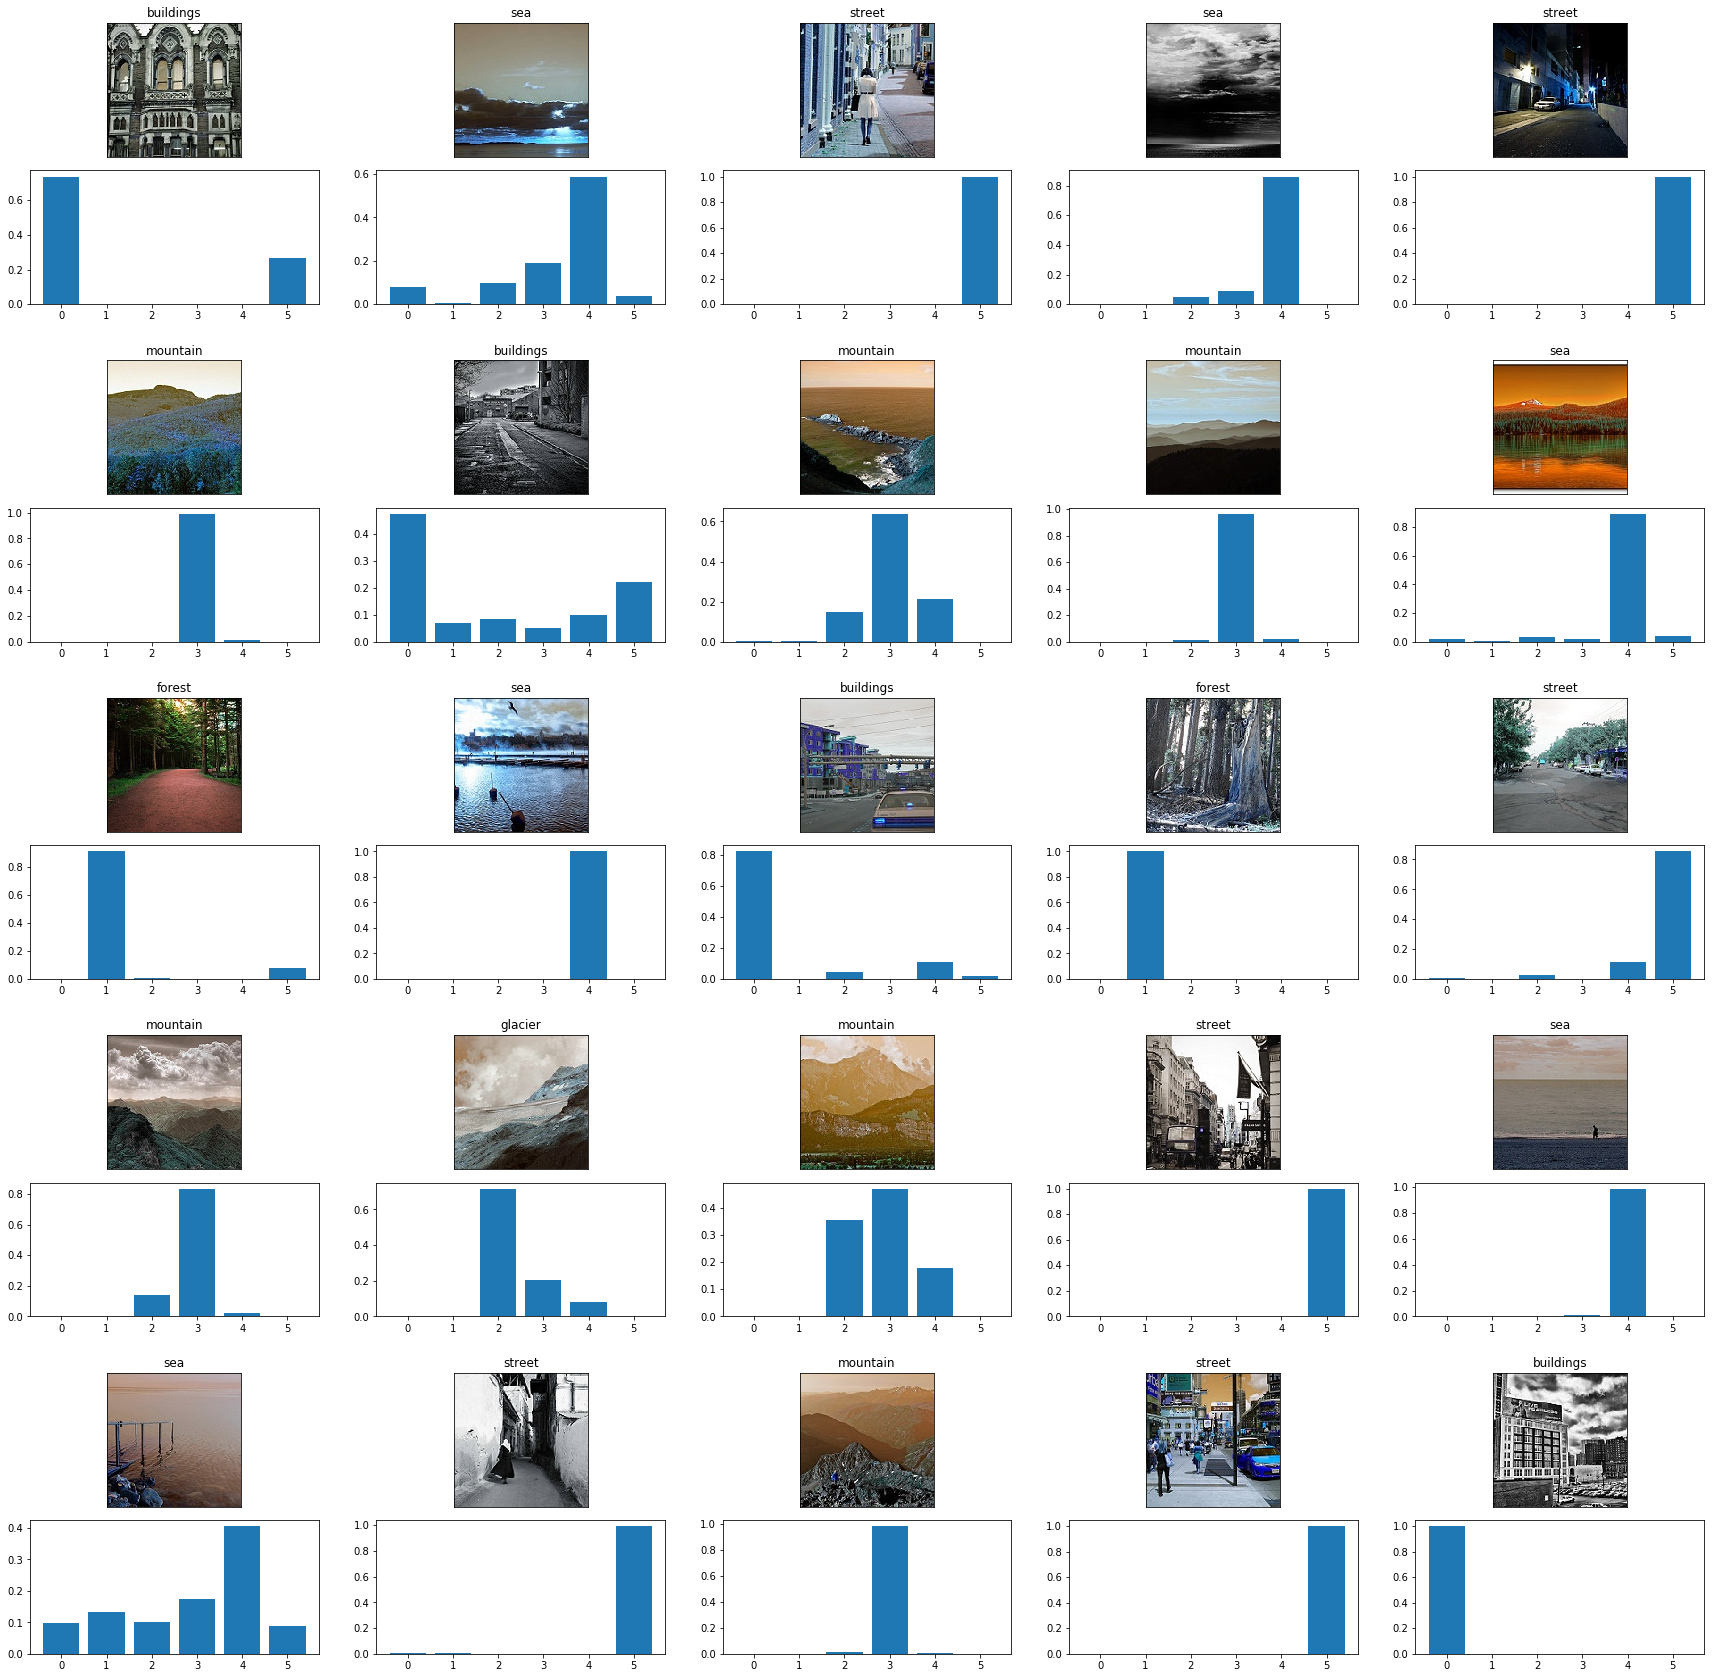

In [12]:
fig = plt.figure(figsize=(30, 30))
outer = gridspec.GridSpec(5, 5, wspace=0.2, hspace=0.2)

for i in range(25):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    rnd_number = randint(0,len(pred_images))
    pred_image = np.array([pred_images[rnd_number]])
    pred_class = get_classlabel(model.predict_classes(pred_image)[0])
    pred_prob = model.predict(pred_image).reshape(6)
    for j in range(2):
        if (j%2) == 0:
            ax = plt.Subplot(fig, inner[j])
            ax.imshow(pred_image[0])
            ax.set_title(pred_class)
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)
        else:
            ax = plt.Subplot(fig, inner[j])
            ax.bar([0,1,2,3,4,5],pred_prob)
            fig.add_subplot(ax)


fig.show()